# Malicous Domain Dataset Preprocessing

In [117]:
import pandas as pd

datasource = "dataset.csv"
data = pd.read_csv(datasource)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Domain               90000 non-null  int64  
 1   DNSRecordType        90000 non-null  object 
 2   MXDnsResponse        90000 non-null  bool   
 3   TXTDnsResponse       90000 non-null  bool   
 4   HasSPFInfo           90000 non-null  bool   
 5   HasDkimInfo          90000 non-null  bool   
 6   HasDmarcInfo         90000 non-null  bool   
 7   Ip                   90000 non-null  int64  
 8   DomainInAlexaDB      90000 non-null  bool   
 9   CommonPorts          90000 non-null  bool   
 10  CountryCode          60948 non-null  object 
 11  RegisteredCountry    12226 non-null  object 
 12  CreationDate         90000 non-null  int64  
 13  LastUpdateDate       90000 non-null  int64  
 14  ASN                  90000 non-null  int64  
 15  HttpResponseCode     90000 non-null 

In [118]:
data.describe()

,Domain,Ip,CreationDate,LastUpdateDate,ASN,HttpResponseCode,SubdomainNumber,Entropy,EntropyOfSubDomains,StrangeCharacters,ConsoantRatio,NumericRatio,SpecialCharRatio,VowelRatio,ConsoantSequence,VowelSequence,NumericSequence,SpecialCharSequence,DomainLength,Class
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,44999.500000,13479.648033,1.933611,2.365744,23335.808167,0.667033,103.069200,2.866844,0.003178,3.498011,0.459519,0.144281,0.006526,0.261528,2.719222,1.342756,1.516478,0.112378,26.440422,0.500000
std,25980.906451,4160.266410,1.997232,1.935509,37004.865724,1.203285,4243.802846,0.488291,0.081042,4.471591,0.146031,0.147331,0.026162,0.098600,1.699339,0.554527,1.538932,0.431967,22.341135,0.500003
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,22499.750000,11709.750000,0.000000,0.000000,-1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.200000,2.000000,1.000000,0.000000,0.000000,15.000000,0.000000
50%,44999.500000,14626.000000,0.000000,4.000000,26228.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.500000,0.100000,0.000000,0.200000,2.000000,1.000000,1.000000,0.000000,24.000000,0.500000
75%,67499.250000,16984.000000,4.000000,4.000000,26228.000000,2.000000,57.000000,3.000000,0.000000,7.000000,0.600000,0.300000,0.000000,0.300000,3.000000,2.000000,3.000000,0.000000,31.000000,1.000000
max,89999.000000,16984.000000,4.000000,4.000000,398108.000000,5.000000,661909.000000,5.000000,3.000000,124.000000,1.000000,0.800000,0.900000,0.800000,37.000000,7.000000,45.000000,61.000000,153.000000,1.000000


## Feature Cleaning and Selection

### Domain

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | N/A           |

The anonymized domain name. Anonymized by mapping a unique domain name to a unique integer (ie `google.com -> 1`).

In [119]:
# Are there any duplicate rows?
print("Duplicate values: %d" % (data["Domain"].size - data["Domain"].unique().size))

# Are there any null values?
print("Null values: %d" % (data["Domain"].isnull().sum()))

Duplicate values: 0
Null values: 0


The domain feature is the base feature of this dataset. That is, all other features are derived from the domain name. Thus we do not want to use this feature in a model and we remove it from the dataset.

In [120]:
data = data.drop(columns=["Domain"])

### DNSRecordType

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | N/A           |

The DNS record type. Types are one of the following:

|  Type   | Description |
| :-----: | :---------: |
| A       | IPv4 Record |
| AAAA    | IPv6 Record |
| CNAME   | Canonical Name Record |
| MX      | Mail Exchange Record  |

In [121]:
# Get class breakdown of domains based on this feature
data.groupby(["DNSRecordType", "Class"]).agg({"Class": "count"})

Class
DNSRecordType Class       
A             0      45000
              1       4529
CNAME         1      35997
MX            1       4474

The dataset does not have a good mix of records -> classes. Both CNAME and MX have zero non malicious data points. Thus this feature must be discarded.

In [122]:
data = data.drop(columns=["DNSRecordType"])

### MXDnsResponse

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

Whether or not a request for MX info returns information.

In [123]:
# Get class breakdown of domains based on this feature
data.groupby(["MXDnsResponse", "Class"]).agg({"Class": "count"})

Class
MXDnsResponse Class       
False         0      30400
              1      37057
True          0      14600
              1       7943

### TXTDnsResponse

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

Whether or not a request for TXT info returns information.

In [124]:
# Get class breakdown of domains based on this feature
data.groupby(["TXTDnsResponse", "Class"]).agg({"Class": "count"})

Class
TXTDnsResponse Class       
False          0      34388
               1      10171
True           0      10612
               1      34829

### HasSPFInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Sender Policy Framework (SPF) attribute. SPF records list the servers authorized to send messages on behalf of a domain and are used to combat email spoofing.

In [125]:
# Get class breakdown of domains based on this feature
data.groupby(["HasSPFInfo", "Class"]).agg({"Class": "count"})

Class
HasSPFInfo Class       
False      0      35218
           1      10561
True       0       9782
           1      34439

### HasDkimInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Domain Keys Identified Mail (DKIM) attribute. DKIM records store the public key used to verify the authenticity of emails and are used to help prevent domian spoofing.

In [126]:
# Get class breakdown of domains based on this feature
data.groupby(["HasDkimInfo", "Class"]).agg({"Class": "count"})

Class
HasDkimInfo Class       
False       0      44981
            1      44997
True        0         19
            1          3

As such a small quantity of domains in the dataset have DKIM information we will remove the feature.

In [127]:
data = data.drop(columns=["HasDkimInfo"])

### HasDmarcInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Domain-based Message Authentication and Conformance (DMARC) attribute. DMARC records specify policy for what happens to emails after they pass or fail SPF and DKIM checks.

In [128]:
# Get class breakdown of domains based on this feature
data.groupby(["HasDmarcInfo", "Class"]).agg({"Class": "count"})

Class
HasDmarcInfo Class       
False        0      43755
             1      44454
True         0       1245
             1        546

### IP

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | null          |

The anonymized internet protocol (IP) address associated with the domain. This feature is irrelevant to the model so it will be removed.

In [129]:
data = data.drop(columns=["Ip"])

### DomainInAlexaDB

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the domain is registered in the Alexa top sites database.

In [130]:
# Get class breakdown of domains based on this feature
data.groupby(["DomainInAlexaDB", "Class"]).agg({"Class": "count"})

Class
DomainInAlexaDB Class       
False           0      43469
                1      44406
True            0       1531
                1        594

### CommonPorts

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the domain has an available service on any of the following common ports: 80, 443, 21, 22, 23, 25, 53, 110, 143, 161, 445, 465, 587, 993, 995, 3306, 3389, 7547, 8080, 8888.

In [131]:
# Get class breakdown of domains based on this feature
data.groupby(["CommonPorts", "Class"]).agg({"Class": "count"})

Class
CommonPorts Class       
False       0      36815
            1      41335
True        0       8185
            1       3665

### CountryCode

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | null         |

The country code associated with the domain's IP address. The publishers of this dataset suggest that the country code data is likely skewed by sinkhole DNS servers which point known bad domains to known safe addresses. Thus this data will be discarded.

<AxesSubplot:title={'center':'Top 10 IP Country Codes'}>

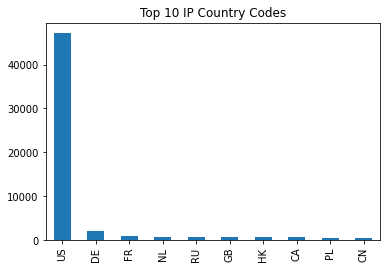

In [132]:
# Plot a barchart displaying the domain counts for the top ten countries
data.CountryCode.value_counts().head(10).plot.bar(title="Top 10 IP Country Codes")

In [133]:
data = data.drop(columns=["CountryCode"])

### RegisteredCountry

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | null          |

The country code associated with the domain's registration information.

<AxesSubplot:title={'center':'Top 10 Registration Country Codes'}>

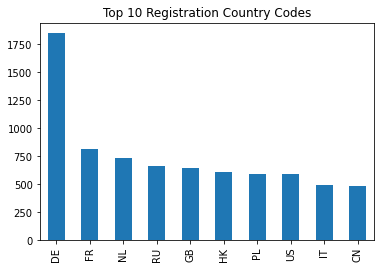

In [134]:
# Plot a barchart displaying the domain counts for the top ten countries
data.RegisteredCountry.value_counts().head(10).plot.bar(title="Top 10 Registration Country Codes")

Note how this distribution significantly differs from the IP based country code data.

In [135]:
# Get class breakdown of domains based on this feature
data.groupby(["RegisteredCountry", "Class"]).agg({"Class": "count"})

Class
RegisteredCountry Class       
AD                1          1
AE                0          5
AL                1          1
AT                0         34
                  1         25
...                        ...
ru                1          1
tr                1          1
ua                0          1
us                1          1
vn                0          6

[175 rows x 1 columns]

In [136]:
# Are there any null values?
print("Null values: %d" % (data["RegisteredCountry"].isnull().sum()))

Null values: 77774


Discarding this feature due to the large volume of null values and the small sample sizes for many countries.

In [137]:
data = data.drop(columns=["RegisteredCountry"])

### CreationDate

|  Type   | Default Value |
| :-----: | :-----------: |
| Enum    | null          |

The age of the domain enumerated into the following bins:

| Enum | Date      |
| :--: | :-------: |
| 0    | No Data   |
| 1    | < 1 month |
| 2    | < 6 months |
| 2    | < 1 year |
| 2    | >= 1 year |

In [138]:
# Get class breakdown of domains based on this feature
data.groupby(["CreationDate", "Class"]).agg({"Class": "count"})

Class
CreationDate Class       
0            0      33714
             1      12711
1            0         11
             1         10
2            0         45
             1          3
3            0         97
             1         19
4            0      11133
             1      32257

### LastUpdateDate

|  Type   | Default Value |
| :-----: | :-----------: |
| Enum    | null          |

The time since the reigstration information was last updated enumerated into the following bins:

| Enum | Date      |
| :--: | :-------: |
| 0    | No Data   |
| 1    | < 1 month |
| 2    | < 6 months |
| 2    | < 1 year |
| 2    | >= 1 year |

In [142]:
# Get class breakdown of domains based on this feature
data.groupby(["LastUpdateDate", "Class"]).agg({"Class": "count"})

Class
LastUpdateDate Class       
0              0      25738
               1       9715
1              0        212
               1        108
2              0       1112
               1        431
3              0        955
               1        270
4              0      16983
               1      34476

### ASN

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | -1            |

The Autonomous System Number (ASN) associated with the domain's IP address. Discarding for simillar reasons to the country code feature and the large volume of missing values.

<AxesSubplot:title={'center':'Top 10 ASNs'}>

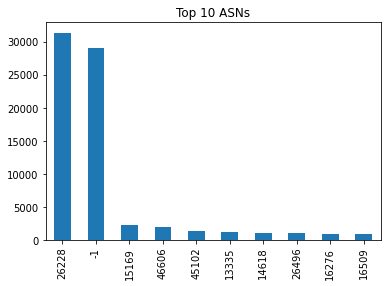

In [143]:
# Plot a barchart displaying the domain counts for the top ten ASNs
data.ASN.value_counts().head(10).plot.bar(title="Top 10 ASNs")

In [144]:
data = data.drop(columns=["ASN"])